Mauri Leino

# Harjoitustyö vaihe 6 - Toimeenpano

__Pistetavoite: 2__

Viimeisessä harjoitustyön vaiheessa tavoitteena on tehdä loppukäyttäjälle ainakin jollain tasolla interaktiivinen sovellus, johon käyttäjä voi syöttää asuntonsa tietoja, ja sen jälkeen sovellus laskee asunnolle ennustetun hinnan ja näyttää asunnon kartalla. Sovellus on siis tietyllä tasolla vuorovaikutteinen vaikka Notebook-pohjainen onkin. Toki tämä on hieman kömpelö ratkaisu, mutta hienomman konsolin tekeminen olisi vaatinut osaamista ja aikaa joista kumpaakaan ei minulta valitettavasti löytynyt. Lisäksi yksi iso miinus loppukäyttäjää ajatellen on se, että mallin opettaminen kestää melko kauan, mutta se onneksi täytyy tehdä ainoastaan kerran.

## Valmisteluvaihe

Tässä osiossa luetaan data, määritellään tarpeellisia funktioita ja opetetaan datan pohjalta malli, jolla voidaan myöhemmin ennustaa asunnon hintaa sijainnin, huoneistotyypin ja asuinalueen perusteella. Viimeisenä myös luodaan pohjat kartoille, joita voidaan hyödyntää visualisoinneissa. Nämä solut tulee ajaa kerran läpi, kun sovellusta ottaa käyttöön.

In [8]:
import pandas as pd
import numpy as np
import mpu
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn import ensemble
from sklearn.cluster import KMeans
from sklearn.model_selection import GridSearchCV
import sklearn.metrics as metrics
import folium
from folium.plugins import MousePosition

df = pd.read_csv('data.csv')
df = df.drop(['Unnamed: 0','latitude', 'longitude', 'neighbourhood_cleansed', 'room_type', 'accommodates', 'bedrooms', 'beds', 'number_of_reviews', 'review_scores_rating', 'review_scores_location'], axis=1)

In [5]:
# This cell contains the model for predicting the price of an apartment
n_est = 600

tuned_parameters = {
    "n_estimators": [ n_est ],
    "max_depth" : [ 4 ],
    "learning_rate": [ 0.01 ],
    "loss" : [ 'squared_error', 'absolute_error' ]
}

gbr = ensemble.GradientBoostingRegressor()
clf = GridSearchCV(gbr, cv=3, param_grid=tuned_parameters,
        scoring='neg_median_absolute_error')
preds = clf.fit(df.drop(['price'], axis = 1), df.price)
model = clf.best_estimator_

Toteutin tähän vaiheeseen kohteiden klusteroinnin, joka suoritetaan laskettaessa asunnon etäisyyttä eri kohteisiin. Ajatuksena on siis se, että kohteet jaetaan klustereihin, ja sen jälkeen selvitetään mihin klusteriin tarkasteltava piste kuuluu. Tällöin etäisyydet tarvitsee laskea vain tiettyyn määrään lähimmistä kohteista, vaikka tietysti neljä klusteria Lontoon kokoisella alueella jättää esimerkiksi pubeja vielä aika monta yhteen klusteriin. Tämä ominaisuus olisi kenties ollut myös enemmän paikallaan datan jalostusvaiheessa kun pyörittelin koko Airbnb-datasettiä jossa oli useita kymmeniä tuhansia datarivejä, nyt kun etäisyydet lasketaan vain yhdelle pisteelle ei klusteroinnista välttämättä ole suurta hyötyä jos lainkaan. Mutta tulipa harjoiteltua kuitenkin. Lisäksi kmeans-mallit saattaisi kannattaa ottaa talteen jotta klusterointia ei tehtäisi aina uudestaan mallin luomiseksi pisteen klusterin selvittämistä varten, mutta yksittäinen ennusteajo ei nytkään kestä kovin kauaa, joten ajanpuutteesta johtuen sovellus jää nyt tähän vaiheeseen.

In [6]:
# Define useful functions and create a model for predictions
def cluster_attractions(df, df_norm):
    kmeans = KMeans(n_clusters=4)
    kmeans.fit(df_norm)
    df['cluster'] = kmeans.labels_
    return df, kmeans

def scale_data(ref_df, apt_loc_df):
    minmax_scaler = preprocessing.MinMaxScaler().fit(ref_df)
    ref_minmax = minmax_scaler.transform(ref_df)
    ref_df_norm = pd.DataFrame(ref_minmax, index=ref_df.index, columns=ref_df.columns)
    apt_minmax = minmax_scaler.transform(apt_loc_df)
    apt_loc_df_norm = pd.DataFrame(apt_minmax, index=apt_loc_df.index, columns=apt_loc_df.columns)
    return ref_df_norm, apt_loc_df_norm
    

def shortest_distance(lat, long, file):
    cols = ['latitude', 'longitude']
    attraction_df = pd.read_csv(file + '.csv', usecols=cols)
    apt_loc_df = pd.DataFrame(data={'longitude': [long], 'latitude': [lat]})
    attraction_df_norm, apt_loc_df_norm = scale_data(attraction_df, apt_loc_df)
    attraction_df, kmeans = cluster_attractions(attraction_df, attraction_df_norm)
    cluster = kmeans.predict(apt_loc_df_norm)[0]
    attraction_df = attraction_df.loc[attraction_df['cluster'] == cluster].reset_index(drop=True)
    first_found = False
    for i in range(len(attraction_df)):
        dist = mpu.haversine_distance((lat, long), (attraction_df['latitude'][i], attraction_df['longitude'][i]))
        if not first_found:
            first_found = True
            shortest = dist
        elif dist < shortest:
            shortest = dist
    return shortest

def onehot_as_df(room_type, neighbourhood):
    zeros_rt = ['Entire home/apt', 'Hotel room', 'Private room', 'Shared room']
    zeros_nh = []
    for column in pd.get_dummies(pd.read_csv('data.csv', usecols=['neighbourhood_cleansed'])['neighbourhood_cleansed']).columns:
        zeros_nh.append(column)
    zeros = zeros_nh + zeros_rt
    frame = pd.DataFrame(columns=zeros, dtype=int)
    for column in zeros:
        frame[column] = [0]
    frame[room_type] = [1]
    frame[neighbourhood] = [1]
    return frame.copy()

def apartment_datavector(lat, long, room_type, neighbourhood):
    dist_vector = pd.DataFrame()
    for file in ['cinemas', 'museums', 'musicvenues', 'pubs']:
        dist_lst = []
        dist_lst.append(shortest_distance(lat, long, file))
        dist_vector[file] = dist_lst
    
    return pd.concat([onehot_as_df(room_type, neighbourhood), dist_vector], axis = 1)

def predict_price(lat, long, room_type, neighbourhood):
    apt_datavect = apartment_datavector(lat, long, room_type, neighbourhood)
    #print(apt_datavect.info())
    #print(apt_datavect.columns)
    #print(apt_datavect)
    prediction = model.predict(apt_datavect)
    return prediction
    

Aiemmin määriteltyjä funktioita sekä opetettua mallia hyödyntäen yritetään nyt ennustaa asunnon hintaa sijainnin ja huonetyypin sekä naapuruston perusteella. Katsotaan ensin vielä eri muuttujien merkitys mallissa.

Text(0.5, 1.0, 'Variable Importance')

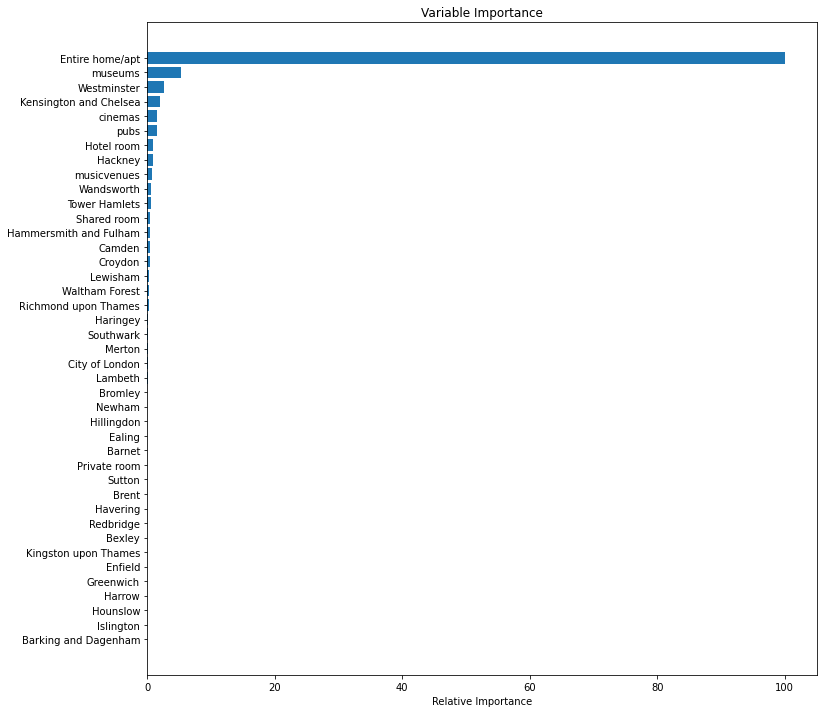

In [9]:
feature_importance = clf.best_estimator_.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
pvals = feature_importance[sorted_idx]
pcols = df.drop(['price'], axis = 1).columns[sorted_idx]
plt.figure(figsize=(12,12))
plt.barh(pos, pvals, align='center')
plt.yticks(pos, pcols)
plt.xlabel('Relative Importance')
plt.title('Variable Importance')

## Hintaennustin

In [11]:
LONDON_COORDINATES=[51.507222, -0.1275]

url = "https://skgrange.github.io/www/data/london_boroughs.json"

interactive_map = folium.Map(location=LONDON_COORDINATES, zoom_start=12.5, height=530)

interactive_map.add_child(folium.LatLngPopup())
folium.GeoJson(url, name="geojson", popup=folium.GeoJsonPopup(fields=['name'])).add_to(interactive_map)

folium.map.LayerControl('topleft', collapsed=False).add_to(interactive_map)

MousePosition().add_to(interactive_map)

interactive_map

Yläpuolella olevasta kartasta saat tietää sekä asuinalueen että koordinaatit. Kun vasemmassa yläkulmassa näkyvä 'geojson'-valitsin on valittuna, näyttää alueen klikkaaminen alueen nimen. Kun 'geojson' ei ole päällä, saa klikkaamalla jotain kohtaa kartasta näkyviin koordinaatit. Kursorin kohdalla olevan pisteen koordinaatit näkyy aina myös kartan oikeassa alakulmassa. Täydennä asunnon tiedot alla olevalle riville ja aja solu. Saat asunnolle lasketun hinnan ja kohteen alapuolella olevalle kartalle. Mahdollisia huonetyyppejä ovat 'Entire home/apt', 'Hotel room', 'Private room' ja 'Shared room'.

In [13]:
# This is the row to modify, input data and run the sell with Ctrl+Enter
lat, long, room_type, neighbourhood = 51.5176, -0.1076, 'Hotel room', 'City of London'

# ------------------------------------------------------------------------------------------

prediction = predict_price(lat, long, room_type, neighbourhood)
print(f"Calculated price for apartment is {prediction[0]:0.2f} euros")

listing = list(zip([lat], [long]))

folium.Marker(
    [lat, long], popup=round(prediction[0], 2).astype('str') + " euros for " + room_type
).add_to(interactive_map)

interactive_map

Calculated price for apartment is 91.83 euros


## Mietteitä ja linkkejä

<ul>
    <li>Lopullisessa sovelluksessa yhdistyy tietyllä tasolla vuorovaikutteisuus ja ohjaava analytiikka, vaikkakin hieman kehnolla toteutuksella. Olen kuitenkin tyytyväinen lopputulokseen, ja harjoitustyöstä jäi ennen kaikkea suuri määrä oppia talteen.
    <li>Kokonaisuutena tuli huomattua hyvinkin konkreettisesti se, että kun hommat toimii niin on helppoa ja kivaa, mutta joskus lopulta pienen ongelman kanssa saa painia tuntikausia. 
    <li>Tuli myös vahvistettua sitä näkemystä, että avoimen lähdekoodin projektien dokumentaation taso vaihtelee todella paljon. Tässäkin työssä sai välillä lyödä päätä seinään huonon/vanhentuneen dokumentaation kanssa. Myös sitä ajatellen kannattaisi kenties varata hieman enemmän aikaa tekemiselle, vaikkei nytkään ihan viime tipassa tullut aloitettua.
    <li>Vaikken lähtenytkään keräämään omaa dataa, vaan "tyydyin" tekemään harjoitustyön Airbnb-datalla, sai siitä silti lopulta varsin mielenkiintoisia tuloksia, etenkin kun sain yhdistettyä siihen hiukan muutakin dataa.
    <li>Kenties hyödyllisimpiä lähteitä olivat muiden tekemät harjoitustyöt, niillä pääsi todella hyvin alkuun esimerkiksi kehitysympäristön suhteen.
    <li>Pandasin dokumentaatio: <u><a href="https://pandas.pydata.org/docs/index.html" target="_blank">https://pandas.pydata.org/docs/index.html</a></u>
    <li>Scikit dokumentaatio: <u><a href="https://scikit-learn.org/stable/user_guide.html" target="_blank">https://scikit-learn.org/stable/user_guide.html</a></u>
    <li>Folium dokumentaatio: <u><a href="https://python-visualization.github.io/folium/index.html" target="_blank">https://python-visualization.github.io/folium/index.html</a></u>
</ul>